In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Загрузка данных

In [2]:
train = pd.read_csv('./data/train.csv', header=0, sep=';')
test = pd.read_csv('./data/test.csv', header=0, sep=';')

In [3]:
print train.shape
print test.shape

(70000, 13)
(30000, 12)


In [4]:
train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
train.gluc.value_counts()

1    59479
3     5331
2     5190
Name: gluc, dtype: int64

Признаки количественные:
* age - возраст (в днях)
* height - рост (в см)
* weight - вес (в кг)
* ap_hi - артериальное давление верхнее
* ap_lo - артериальное давление высокое 
    
Признаки номинальные:
* gender - пол 
* cholesterol - уровень холестерина
* gluc - уровень глюкозы
* smoke - курение
* alco - употребление алкоголы
* active - наличие физической активности
    
cardio - выходная переменная

# Предварительный анализ

Проверим данные на пропуски.

In [6]:
for col in ['smoke','alco','active']:
    print test[col].value_counts()

0       24601
None     3030
1        2369
Name: smoke, dtype: int64
0       25500
None     3031
1        1469
Name: alco, dtype: int64
1       21843
0        5260
None     2897
Name: active, dtype: int64


В трейне нет, а вот в тесте есть. Нужно будет их как-то заполнять.

Проверим теперь на дубликаты.

In [7]:
print train.drop('cardio',axis=1).duplicated().value_counts()
print test.duplicated().value_counts()

False    70000
dtype: int64
False    30000
dtype: int64


Дубликатов нет.

### Возраст

In [8]:
train.age.dtype

dtype('int64')

In [9]:
train.age.describe()

count    70000.000000
mean     19468.865814
std       2467.251667
min      10798.000000
25%      17664.000000
50%      19703.000000
75%      21327.000000
max      23713.000000
Name: age, dtype: float64

In [10]:
train['age_year'] = train['age']/365

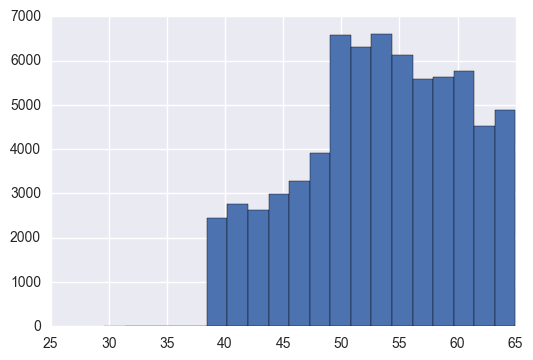

In [11]:
train['age_year'].hist(bins=20)

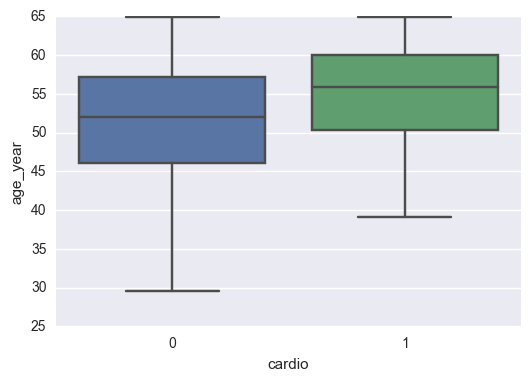

In [12]:
sns.boxplot(x='cardio',y='age_year',data=train)

### Рост

In [13]:
train.height.dtype

dtype('int64')

In [14]:
train.height.describe()

count    70000.000000
mean       164.359229
std          8.210126
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

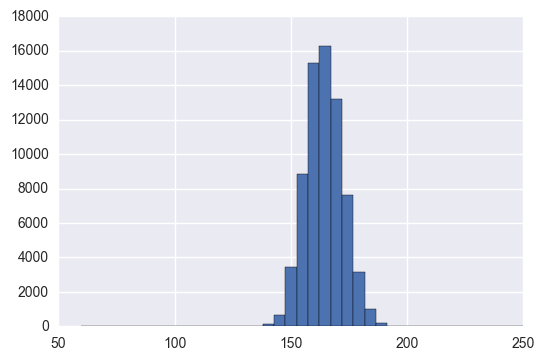

In [15]:
train.height.hist(bins=40)

Посмотрим на выбросы.

In [16]:
train[train.height < 130]['height'].count()

92

In [17]:
train[train.height > 210]['height'].value_counts()

250    1
Name: height, dtype: int64

Выбросы есть. С ними нужно будет что-то сделать. Варианты:
    1. Удалить такие записи
    2. Заполнить минимальным
    3. Заполнить средним по выборке
    4. Подставить слева 1-ку (?)
    5. Поставить спецаильное число, обозначающее выброс

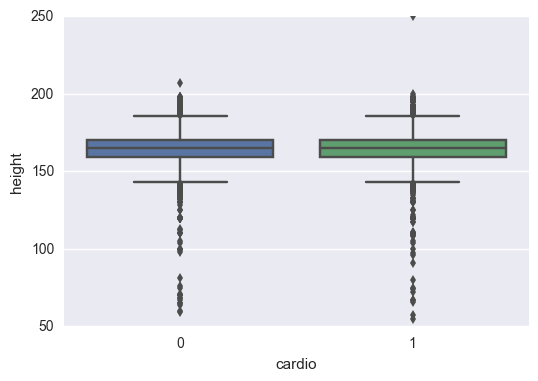

In [18]:
sns.boxplot(x='cardio',y='height',data=train)

Видно, что рост не влияет на выходной признак.

### Вес

In [19]:
train.weight.dtype

dtype('float64')

In [20]:
train.weight.describe()

count    70000.000000
mean        74.205690
std         14.395757
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

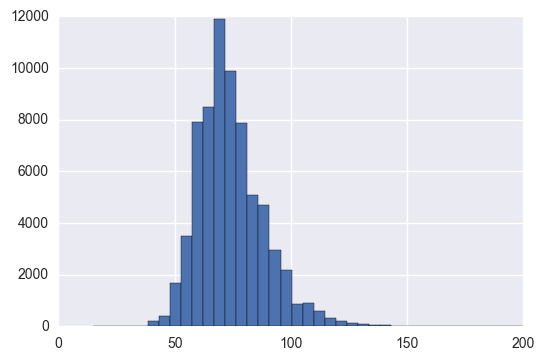

In [21]:
train.weight.hist(bins=40)

Посмотрим на выбросы.

In [22]:
train[train.weight < 40].weight.value_counts()

39.00    9
38.00    8
37.00    7
36.00    5
34.00    4
32.00    3
30.00    3
33.00    2
35.00    2
31.00    1
35.45    1
28.00    1
23.00    1
22.00    1
21.00    1
11.00    1
10.00    1
29.00    1
Name: weight, dtype: int64

In [23]:
train[train.weight > 170].weight.value_counts()

180.0    4
178.0    3
200.0    2
175.0    1
172.0    1
171.0    1
183.0    1
181.0    1
177.0    1
Name: weight, dtype: int64

Выбросы скорее есть снизу. Сверху можно и не ограничивать, а вот снизу придется почистить.

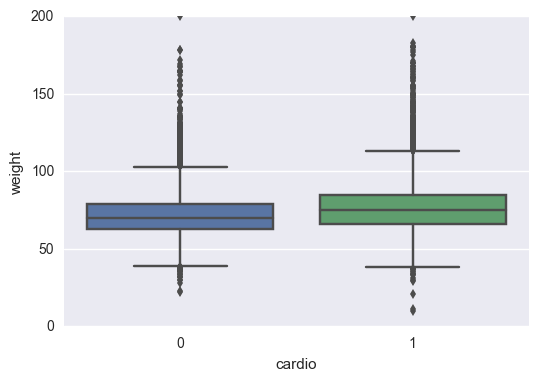

In [24]:
sns.boxplot(x='cardio',y='weight',data=train)

Вес немножечко влияет на выходную переменную.

### Индекс массы тела

Посчитаем индекс массы тела https://ru.wikipedia.org/wiki/Индекс_массы_тела.

In [25]:
train['BMI'] = train.apply(lambda x: (x.weight)/((x.height/100)**2), axis=1)

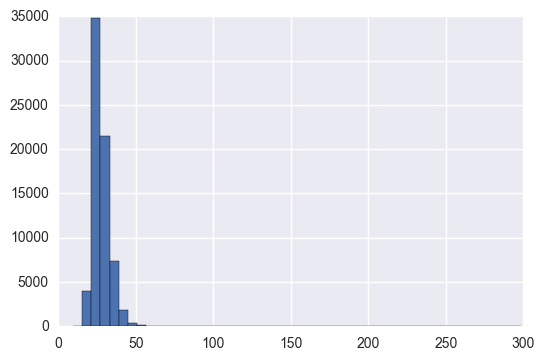

In [26]:
train['BMI'].hist(bins=50)

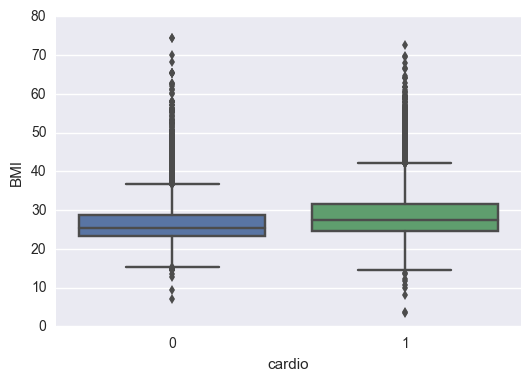

In [27]:
sns.boxplot(x='cardio',y='BMI',data=train[train.BMI < 80])

Много выбросов. Попробуем посчитать средние cardio для превышающих BMI 30 и не превышающих.

In [28]:
print 'BMI > 30, Cardio mean: ', train[train.BMI > 30].cardio.mean()
print 'BMI < 30, Cardio mean: ', train[train.BMI < 30].cardio.mean()

BMI > 30, Cardio mean:  0.630704271098
BMI < 30, Cardio mean:  0.452742304856


Тоже самое для 40.

In [29]:
print 'BMI > 40, Cardio mean: ', train[train.BMI > 40].cardio.mean()
print 'BMI < 40, Cardio mean: ', train[train.BMI < 40].cardio.mean()

BMI > 40, Cardio mean:  0.688568376068
BMI < 40, Cardio mean:  0.494465161347


Можно будет использовать в качестве признака.

###  Давление верхнее

In [30]:
train.ap_hi.dtype

dtype('int64')

In [31]:
train.ap_hi.describe()

count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

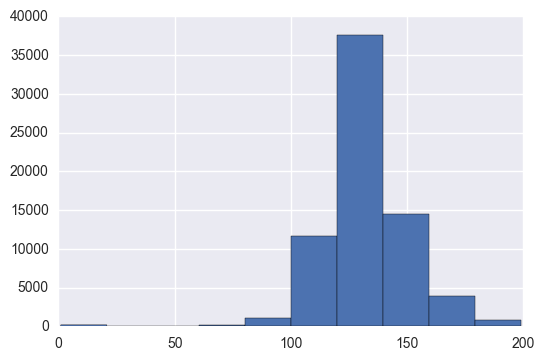

In [32]:
train[(train.ap_hi > 0) & ((train.ap_hi < 200))].ap_hi.hist(bins=10)

Посмотрим на выбросы.

In [33]:
train[(train.ap_hi < 0) | (train.ap_hi > 300)].ap_hi.count()

47

Выбросы тоже нужно будет чистить.

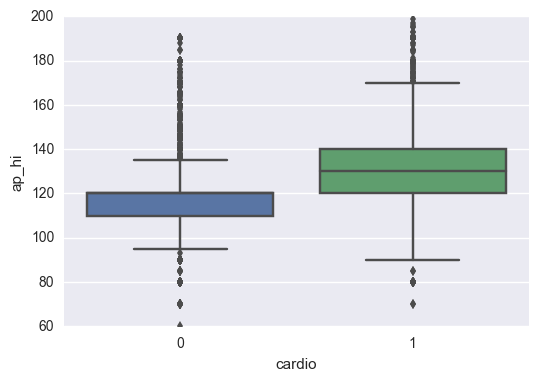

In [34]:
sns.boxplot(x='cardio', y='ap_hi', data=train[(train.ap_hi > 50) & ((train.ap_hi < 200))])

В целом, у людей с высоким систолическим давлением чаще встречаются ССЗ. Логично.

### Давление нижнее

In [35]:
train.ap_lo.dtype

dtype('int64')

In [36]:
train.ap_lo.describe()

count    70000.000000
mean        96.630414
std        188.472530
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64

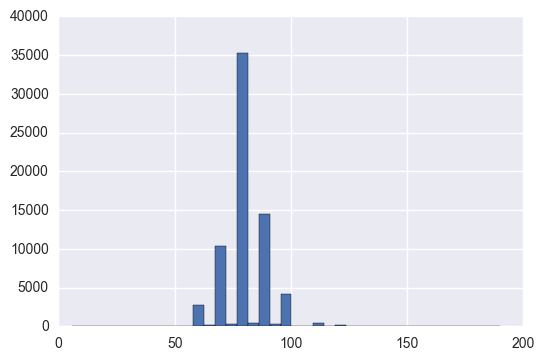

In [37]:
train[(train.ap_lo > 0) & ((train.ap_lo < 200))].ap_lo.hist(bins=40)

Проверим выбросы.

In [38]:
train[(train.ap_lo < 0) | (train.ap_lo > 150)].ap_lo.count()

976

Тоже нужно будет чистить выбросы.

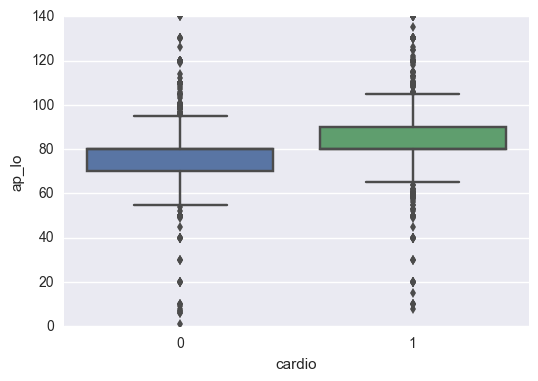

In [39]:
sns.boxplot(x='cardio', y='ap_lo', data=train[(train.ap_lo > 0) & (train.ap_lo < 150)])

Здесь все тоже самое, что с верхним давлением.

### Уровень холестерина

In [40]:
train.cholesterol.dtype

dtype('int64')

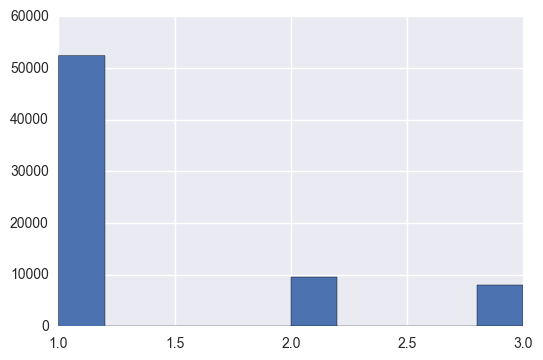

In [41]:
train.cholesterol.hist()

In [42]:
print 'Mean cardio with cholesterol=1: ', train[train.cholesterol == 1].cardio.mean()
print 'Mean cardio with cholesterol=2: ', train[train.cholesterol == 2].cardio.mean()
print 'Mean cardio with cholesterol=3: ', train[train.cholesterol == 3].cardio.mean()

Mean cardio with cholesterol=1:  0.44010690083
Mean cardio with cholesterol=2:  0.602157293957
Mean cardio with cholesterol=3:  0.765435159931


Холестерин достаточно хорошо влияет на значение целевой переменной. Для него нужно считать SLH.

### Уровень глюкозы

In [43]:
train.gluc.dtype

dtype('int64')

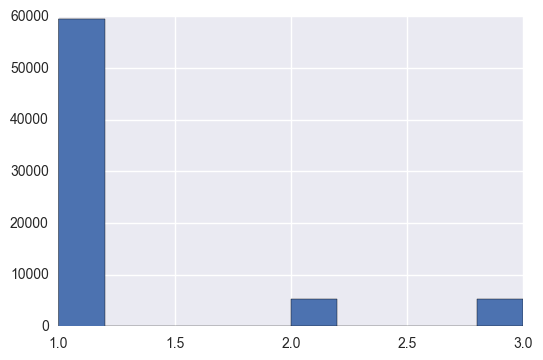

In [44]:
train.gluc.hist()

In [45]:
print 'Mean cardio with gluc=1: ', train[train.gluc == 1].cardio.mean()
print 'Mean cardio with gluc=2: ', train[train.gluc == 2].cardio.mean()
print 'Mean cardio with gluc=3: ', train[train.gluc == 3].cardio.mean()

Mean cardio with gluc=1:  0.480589787992
Mean cardio with gluc=2:  0.593063583815
Mean cardio with gluc=3:  0.622022134684


Уровень глюкозы также логично влияет ССЗ.

### Курение

In [46]:
train.smoke.dtype

dtype('int64')

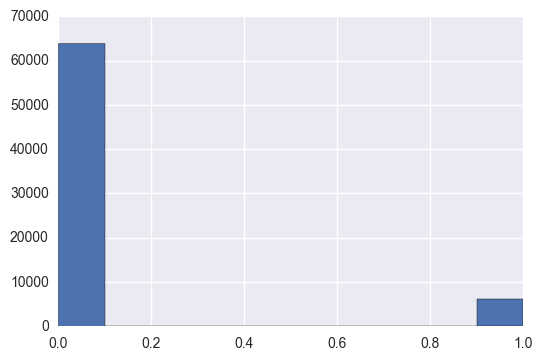

In [47]:
train.smoke.hist()

In [48]:
print 'Mean cardio with smoke=0: ', train[train.smoke == 0].cardio.mean()
print 'Mean cardio with smoke=1: ', train[train.smoke == 1].cardio.mean()

Mean cardio with smoke=0:  0.502107126631
Mean cardio with smoke=1:  0.474793321446


Неожиданно.

### Алкоголь

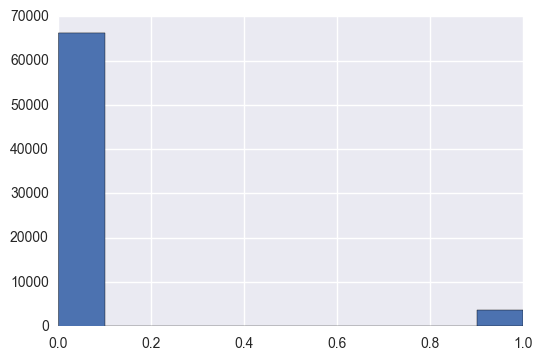

In [49]:
train.alco.hist()

In [50]:
print 'Mean cardio with alco=0: ', train[train.alco == 0].cardio.mean()
print 'Mean cardio with alco=1: ', train[train.alco == 1].cardio.mean()

Mean cardio with alco=0:  0.500573706142
Mean cardio with alco=1:  0.484325185972


### Активность

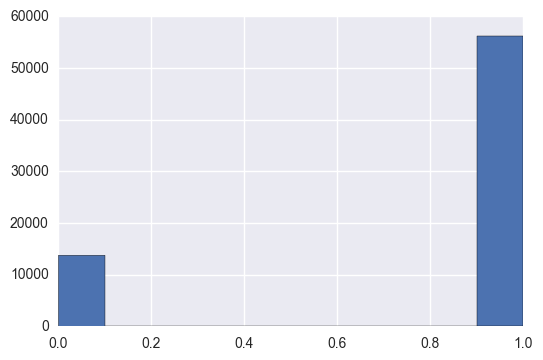

In [51]:
train.active.hist()

In [52]:
print 'Mean cardio with active=0: ', train[train.active == 0].cardio.mean()
print 'Mean cardio with active=1: ', train[train.active == 1].cardio.mean()

Mean cardio with active=0:  0.535774073804
Mean cardio with active=1:  0.490890670269


### Риск ССЗ

# Визуализация с помощью t-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components = 2, init = 'pca', random_state = 0, metric='cosine')
data_tsne = tsne.fit_transform(train)


plt.figure(figsize = (10, 6))
colors = cm.hot(np.linspace(0, 1, len(set(train['cardio']))))
for y, c in zip(set(train['cardio']), colors):
    plt.scatter(data_tsne[train['cardio'].values==y, 0], 
                data_tsne[train['cardio'].values==y, 1], c=c, label=str(y))
plt.legend(loc='upper center', ncol=8, bbox_to_anchor=(0.5,-0.1))